In [1]:
import collections
import matplotlib
import uproot
import sys
import site
import glob
import re
import math
sys.path.insert(0, site.getusersitepackages())

import numpy             as np
import awkward           as ak
import matplotlib.pyplot as plt
import pandas            as pd

# Wider Cells
from IPython.display                 import display, HTML, Markdown
from tqdm.notebook                   import tqdm
from matplotlib.backends.backend_pdf import PdfPages
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [2]:
# Función para extraer el número después de "P"
def extract_p_number(filename):
    match = re.search(r"P(\d+)", filename)
    if match:
        return int(match.group(1))
    return -1  # Devuelve un valor pequeño si no se encuentra "P"

In [124]:
run = 1444
run_files = glob.glob(f"/eos/experiment/wcte/data/2025_commissioning/offline_data/{run}/WCTE_offline_R{run}S*P*.root")
#/eos/experiment/wcte/data/2025_commissioning/"+str(run)+"/*.root

# Ordenar los archivos usando extract_p_number
run_files = sorted(run_files, key=extract_p_number)
len(run_files)

324

In [6]:
# def read_all_parts():
#     tree = uproot.open(files[0])
#     keys = tree.keys()
#     print(keys)

#     branch = tree[keys[0]]
#     primal_event_numbers = [branch['event_number'].array().to_numpy()]
#     primal_window_times  = [branch['window_time'].array().to_numpy()]

#     for f in tqdm(files[1:]):
#         tree2 = uproot.open(f)
#         keys2 = tree2.keys()
#         for key2 in keys2:
#             branch2 = tree2[key2]
#             events = branch2['event_number'].array().to_numpy()
#             if len(events) != 0:
#                 primal_event_numbers.append(branch2['event_number'].array().to_numpy()+primal_event_numbers[-1].max()+1)
#                 primal_window_times.append(branch2['window_time'].array().to_numpy()+primal_window_times[-1].max()+1)   

# Select The Part File You Want To Use

# Select Only Those Events With The Same Number Of Waveforms And Hits

# For Those Good Events, Select Only Hits In Card 130 and Corresponding Channels And Etc

In [132]:
def selectec_good_events(part_file):
    tree = uproot.open(run_files[part_file]+":WCTEReadoutWindows")
    nevents = len(tree["hit_mpmt_card_ids"].array())

    file_hit_card_ids    = tree["hit_mpmt_card_ids"].array()
    file_hit_channel_ids = tree["hit_pmt_channel_ids"].array()
    file_hit_charges     = tree["hit_pmt_charges"].array()
    file_hit_times       = tree["hit_pmt_times"].array()

    file_waveform_card_ids = tree["pmt_waveform_mpmt_card_ids"].array()

    good_events = []

    for ievt in range(nevents):
        numHits = len(file_hit_card_ids[ievt])
        numWave = len(file_waveform_card_ids[ievt])
        if numHits == numWave:
            good_events.append(ievt)
        
    print(f"{len(good_events)/nevents*100:.0f}% of the events are good events")

    return good_events, file_hit_card_ids, file_hit_channel_ids, file_hit_charges, file_hit_times, file_waveform_card_ids

In [133]:
def select_charges_for_beam_monitor(good_events, files, card, channels, plot_control=False, variable="charge"):
    
    file_hit_charges_masked_LChannel = []
    file_hit_charges_masked_RChannel = []

    for ievt in good_events:
        event_hit_card_ids    = files[0][ievt]
        event_hit_channel_ids = files[1][ievt]
        event_hit_charges     = files[2][ievt]
        event_hit_times       = files[3][ievt]

        event_waveform_card_ids = files[4][ievt]

        try:
            len(event_hit_card_ids) == len(event_waveform_card_ids)

        except:
            raise ValueError("This is not a good event, we havae different amount of hits and waveforms!")

        if plot_control:
            # Control Plot: Should Be The Exact Same
            plt.hist(event_hit_card_ids, bins=50, alpha=0.4);
            plt.hist(event_waveform_card_ids, bins=50, alpha=0.4);
            plt.title("Card IDs From Hits and From Waveforms");
            plt.xlabel("Card ID");

        # Create mask to card 130
        # Create mask to channels 7&8 which correspond to ACT3L-R
        # Combine masks
        # Apply masks to event_hit_charges to get the charge in those specific channels for that specific card
        mask_card = event_hit_card_ids == card
        mask_channel_L = (event_hit_channel_ids == channels[0])
        mask_channel_R = (event_hit_channel_ids == channels[1])
        combined_mask_L = mask_card & mask_channel_L
        combined_mask_R = mask_card & mask_channel_R

        if variable == "charge":
            file_hit_charges_masked_LChannel.append(event_hit_charges[combined_mask_L])
            file_hit_charges_masked_RChannel.append(event_hit_charges[combined_mask_R])

        elif variable == "time":
            file_hit_charges_masked_LChannel.append(event_hit_times[combined_mask_L])
            file_hit_charges_masked_RChannel.append(event_hit_times[combined_mask_R])

    file_hit_charges_masked_LChannel = ak.flatten(file_hit_charges_masked_LChannel)
    file_hit_charges_masked_RChannel = ak.flatten(file_hit_charges_masked_RChannel)

    return file_hit_charges_masked_LChannel, file_hit_charges_masked_RChannel

In [134]:
part = 0
good_events, *files = selectec_good_events(part)

39% of the events are good events


In [137]:
# ACT3
file_hit_charges_ACT3L, file_hit_charges_ACT3R = select_charges_for_beam_monitor(good_events, files, 130, [7,8], False)
file_hit_charges_ACT4L, file_hit_charges_ACT4R = select_charges_for_beam_monitor(good_events, files, 130, [9,10], False)

# T1
file_hit_charges_T10L, file_hit_charges_T10R = select_charges_for_beam_monitor(good_events, files, 130, [13,14], False)
file_hit_charges_T11L, file_hit_charges_T11R = select_charges_for_beam_monitor(good_events, files, 130, [15,16], False)

# T0
file_hit_charges_T00L, file_hit_charges_T00R = select_charges_for_beam_monitor(good_events, files, 130, [12,13], False, "time")
file_hit_charges_T01L, file_hit_charges_T01R = select_charges_for_beam_monitor(good_events, files, 130, [14,15], False, "time")

In [140]:
print("ACT3")
print(len(file_hit_charges_ACT3L))
print(f"{len(file_hit_charges_ACT3R)}\n")

print("T1")
print(len(file_hit_charges_T10L))
print(len(file_hit_charges_T10R))
print(len(file_hit_charges_T11L))
print(f"{len(file_hit_charges_T11R)}\n")

print("T0")
print(len(file_hit_charges_T00L))
print(len(file_hit_charges_T00R))
print(len(file_hit_charges_T01L))
print(f"{len(file_hit_charges_T01R)}\n")

ACT3
231
246

T1
505
498
508
391

T0
0
505
498
508



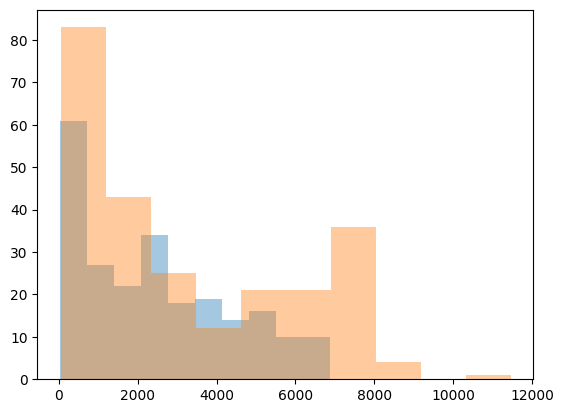

In [130]:
plt.hist(file_hit_charges_ACT3L, alpha=0.4);
plt.hist(file_hit_charges_ACT3R, alpha=0.4);